In [1]:
using Pkg
Pkg.DEFAULT_IO[] = stdout
Pkg.activate("..");
Pkg.status()
#Pkg.add(url="https://github.com/ClimateFluidPhysics-ANU/MixedLayerThermoclineDynamics.jl", rev="master")

  Activating environment at `~/Desktop/PhD/Codes/julia_package/ToyModel.jl/Project.toml`
      Status `~/Desktop/PhD/Codes/julia_package/ToyModel.jl/Project.toml`
  [6e4b80f9] BenchmarkTools v1.1.0
  [ee78f7c6] Makie v0.14.2
  [1d4a6882] MixedLayerThermoclineDynamics v0.1.0 `https://github.com/ClimateFluidPhysics-ANU/MixedLayerThermoclineDynamics.jl#master`
  [6fe1bfb0] OffsetArrays v1.10.2
  [91a5bcdd] Plots v1.16.7


In [2]:
using Plots
using MixedLayerThermoclineDynamics

include("../Staggered/Grid/Periodic_avg.jl")
include("../Staggered/Advection/Periodic_1D.jl")

adv_x_Euler! (generic function with 1 method)

In [3]:
g = 9.81

Lx = 5
nx = 100
grid = Grid1D(nx, -Lx/2, Lx/2);

In [4]:
#Initialising variables
xt = grid.xC
xu = grid.xF
dx = grid.dx

#Tracer and momentum variables
h_old = zeros(nx)
@. h_old = 1 + 0.01*exp(-2*(xt-1)^2)
h_new = zeros(nx)
U_old = zeros(nx)
U_new = zeros(nx)

#Equation variables, modified several times at every time step
adv = zeros(nx)
dUdx = zeros(nx)
dhdx = zeros(nx)
U_avg = zeros(nx)
h_avg = zeros(nx)
flow_sign = zeros(nx)

k1U = zeros(nx)
k2U = zeros(nx)
k3U = zeros(nx)
k4U = zeros(nx)
k1h = zeros(nx)
k2h = zeros(nx)
k3h = zeros(nx)
k4h = zeros(nx)
U_temp = zeros(nx)
h_temp = zeros(nx)

U_right = zeros(nx)
h_right = zeros(nx)

#Time variables
t_start = 0
t_end = 2
dt = 0.0001

#Needed for making animations
n_steps = Int(t_end/dt)
h_data = zeros(nx, n_steps+1)
U_data = zeros(nx, n_steps+1)
count = 1

1

In [5]:
function RHS!(U_right, h_right, U, h, U_avg, h_avg, adv, dUdx, dhdx, flow_sign, grid, g)
    @. flow_sign = sign(U)
    avg_val(U, h, U_avg, h_avg, grid)
    adv_x_Euler!(adv, dUdx, U.*U./h_avg, flow_sign, grid)
    ∂xt_cd!(dhdx, h.^2, grid, true)
    ∂xu_cd!(dUdx, U, grid, true)
    
    @. U_right = - adv - 0.5*g*dhdx
    @. h_right = - dUdx
end

function RK4(dt, U, h, k1U, k2U, k3U, k4U, k1h, k2h, k3h, k4h, U_right, h_right, U_avg, h_avg, adv, dUdx, dhdx, flow_sign, grid, g)
    
    #Step 1
    RHS!(k1U, k1h, U, h, U_avg, h_avg, adv, dUdx, dhdx, flow_sign, grid, g)
    
    #Step 2
    @. U_temp = U + dt/2*k1U
    @. h_temp = h + dt/2*k1h
    RHS!(k2U, k2h, U_temp, h_temp, U_avg, h_avg, adv, dUdx, dhdx, flow_sign, grid, g)
    
    #Step 3
    @. U_temp = U + dt/2*k2U
    @. h_temp = h + dt/2*k2h
    RHS!(k3U, k3h, U_temp, h_temp, U_avg, h_avg, adv, dUdx, dhdx, flow_sign, grid, g)
    
    #Step 4
    @. U_temp = U + dt*k3U
    @. h_temp = h + dt*k3h
    RHS!(k4U, k4h, U_temp, h_temp, U_avg, h_avg, adv, dUdx, dhdx, flow_sign, grid, g)
    
    #Doing weighted average
    @. U = U + dt/6*(k1U + 2*k2U + 2*k3U + k4U)
    @. h = h + dt/6*(k1h + 2*k2h + 2*k3h + k4h)
end

RK4 (generic function with 1 method)

In [6]:
for t in t_start:dt:t_end
    
    RK4(dt, U_old, h_old, k1U, k2U, k3U, k4U, k1h, k2h, k3h, k4h, U_right, h_right, U_avg, h_avg, adv, dUdx, dhdx, flow_sign, grid, g)
    
    h_data[:, count] = h_old
    U_data[:, count] = U_old
    count = count+1
end

┌ Info: Saved animation to 
│   fn = /Users/dhruvbhagtani/Desktop/PhD/Codes/julia_package/ToyModel.jl/1D_SWE/Staggered_Conservative.gif
└ @ Plots /Users/dhruvbhagtani/.julia/packages/Plots/XCJgc/src/animation.jl:104


Plots.AnimatedGif("/Users/dhruvbhagtani/Desktop/PhD/Codes/julia_package/ToyModel.jl/1D_SWE/Staggered_Conservative.gif")
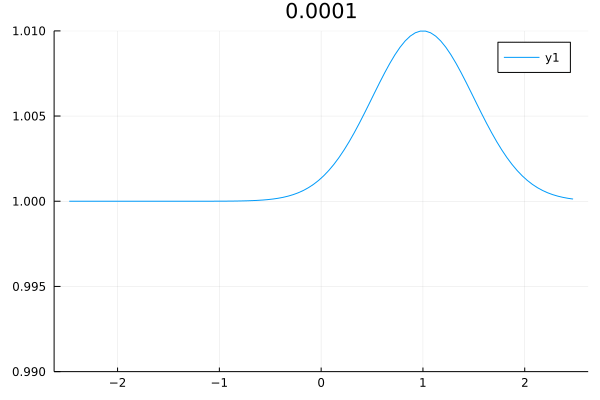

In [7]:
skip = Int(50)
anim = @animate for i in 1:skip:n_steps
    plot(xt, h_data[:, i])
    plot!(ylims = (1 - 0.01, 1 + 0.01))
    title!(string(i*dt))
end

gif(anim, "Staggered_Conservative.gif", fps = 16)